# 1 ISLR Classification Lab

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.naive_bayes import CategoricalNB as CNB
from sklearn.preprocessing import PolynomialFeatures

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style("darkgrid")

## 4.7.1 The Stock Market Data

In [2]:
df = pd.read_csv("Smarket.csv",index_col=0)
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
1,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
2,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
3,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
4,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
5,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1246,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1247,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1248,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1249,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 1 to 1250
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1250 non-null   int64  
 1   Lag1       1250 non-null   float64
 2   Lag2       1250 non-null   float64
 3   Lag3       1250 non-null   float64
 4   Lag4       1250 non-null   float64
 5   Lag5       1250 non-null   float64
 6   Volume     1250 non-null   float64
 7   Today      1250 non-null   float64
 8   Direction  1250 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 97.7+ KB


Here is a summary of all the variables in the dataframe. We can see that all variables are numerical except for `direction`. There are also no null values in the dataframe as well.

In [4]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


Here is a summary table of numerical variables in the dataframe. We can see that the summary statistics of the lags are generally the same. 

In [5]:
df.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


Here is the correlation matrix between all the numerical variables, `Direction` is dropped because it is not numerical. From the matrix, we can see that the correlation of `Volume` and `Year` has a positive correlation of 0.53 while others (between lags) don't seem to have a substantial correlation. We will examine the relationship between `Volume` and `Year` next. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


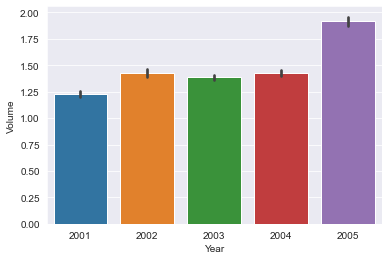

In [6]:
sns.barplot(df.Year, df.Volume)

From this barplot, we can see that as `Year` increases, `Volume` also increases over time. 

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


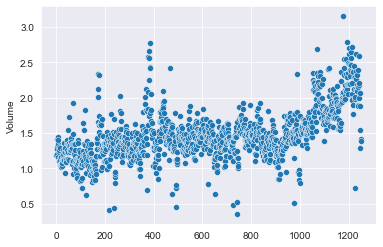

In [7]:
sns.scatterplot(df.index, df.Volume)

Here is a scatterplot of `Volume` over `index`. We can see that the volume is mainly scattered around volume 1.0 to 2.5.

## 4.7.2 Logistic Regression

In [8]:
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
response = 'Direction'

X = df[features]
y = df[response]

logistic_reg = LogisticRegression(penalty='none').fit(X,y)
print(logistic_reg.coef_)
print(logistic_reg.intercept_)

[[-0.07307339 -0.04230074  0.01108552  0.00935968  0.01031339  0.13544567]]
[-0.12600781]


Here we fit the logistic regression model that predicts `direction` based on variables `Lag1` to `Lag5` and `Volume`. `Lag1` and `Lag2` have negative coefficients while others have positive coefficients. 

In [9]:
print(logistic_reg.predict_proba(X)[0:10, 1])
y_pred = logistic_reg.predict(X)
print(y_pred[0:10])

[0.50708369 0.48146717 0.48113874 0.51522232 0.51078106 0.50695658
 0.49265099 0.5092293  0.51761327 0.48883779]
['Up' 'Down' 'Down' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up' 'Down']


Here are the first ten probabilities for the predictions based on the model and the associated response for the dependent variable. 

In [10]:
cfm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0: "Down", 1:"Up"}, inplace = True)

df_cfm

,Down,Up
Down,145,457
Up,141,507


Here is the confusion matrix that gives the true positives, true negatives, false positives, false negatives calculated by our model. 

In [11]:
acc = (tp+tn)/(tp+fn+tn+fp)
acc

0.5216

Here is the percentage 52.16% that classifies the correct prediction of the logistic regression model.

In [12]:
df_train = df.loc[df.Year < 2005]
df_test = df.loc[df.Year == 2005]
print("Training dataset shape: ", df_train.shape)
print("Test dataset shape: ", df_test.shape)

Training dataset shape:  (998, 9)
Test dataset shape:  (252, 9)


Here we split the data into training and test sets based on whether the year is less than 2005 and exactly 2005. We can see that the training dataset has 998 observations while the test dataset has 252 observations.

In [13]:
X_train = df_train[features]
y_train = df_train[response]

logistic_reg2 = LogisticRegression(penalty='none').fit(X_train, y_train)

Here we fit the training data into a logistic regression model.

In [14]:
X_test = df_test[features]
y_test = df_test[response]

y_pred = logistic_reg2.predict(X_test)

We use the training logistic regression model to predict `Direction` on the test set. 

In [15]:
cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down    77  34
Up      97  44


0.4801587301587302

Here is the percentage 48.02% that classifies the correct prediction of the logistic regression model. We can see that the percentage went down compared to the previous model which we have not splitted the data.

In [16]:
features = ['Lag1', 'Lag2']
X_train = df_train[features]
y_train = df_train[response]

logistic_reg = LogisticRegression(penalty='none') 
logistic_reg.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = logistic_reg.predict(X_test)


Due to the decrease in accuracy in the previous model, we suspect that it is due to the insignificant p-values computed in the model. Therefore, we only choose two variables: `Lag1` and `Lag2` and rerun the logistic regression model to see if there is any improvement. 

In [17]:
cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)


acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down   Up
Down    35   76
Up      35  106


0.5595238095238095

Here is the percentage 55.95% that classifies the correct prediction of the newest logistic regression model. We can see that the percentage went up compared to the last model and is a better prediction among all three models we ran. 

In [18]:
acc_up = tp/(tp+fp)
acc_up

0.5824175824175825

Here we calculated the accuracy of the prediction when `Direction` is up and found that the accuracy is 58.24% which is better than the accuracy of the entire model. Therefore, we can predict more accurately when the market shows an upward trend and we can utilize this fact when making predictions.

In [19]:
data = {'Lag1':[1.2, 1.5],'Lag2':[1.1, -0.8]}
df_predict = pd.DataFrame(data)

X_test = df_predict[features]
logistic_reg.predict_proba(X_test)[0:,1]

array([0.47914604, 0.49611109])

Here we predicted the `Direction` with particular values of `Lag1` and `Lag2`. We can see that using first combination we have a predicted value of 0.4791, with second combination we have a predicted value of 0.4961

## 4.7.3 Linear Discriminant Analysis

In [20]:
features = ['Lag1', 'Lag2']
X_train = df_train[features]
y_train = df_train[response]

lda_model = LDA()
lda_model.fit(X_train, y_train)

lda_model.priors_

array([0.49198397, 0.50801603])

Here we fitted a LDA model using the training dataset and calculated that the prior probabilities of groups are 0.492 and 0.508. This means that before fitting the model, we observe 49.2% of observations where the `Direction` is down. 

In [21]:
lda_model.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

Here is the output of group means for the LDA model. We can interpret this as the average prediction of `Direction` based on the two independent variables.

In [22]:
lda_model.scalings_

array([[-0.64201904],
       [-0.51352928]])

Here are the coefficients for `Lag1` and `Lag2`. We can see that the coefficient for `Lag1` is -0.642 and for `Lag2` is -0.514.

In [23]:
X_test = df_test[features]
y_test = df_test[response]
y_pred = lda_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down   Up
Down    35   76
Up      35  106


0.5595238095238095

Here is the percentage 55.95% that classifies the correct prediction of the LDA model. We can see that the percentage is identical to the last logistic regression model computed. 

In [24]:
posterior = pd.DataFrame(lda_model.predict_proba(X_test), columns=['Down','Up'])

sum(posterior['Down']>0.5)

70

If we put a 0.5 threshold to the posterior probabilities, we see that there are 70 predictions that has a threshold greater than 0.5.

In [25]:
print(posterior.iloc[:20])
print(y_pred[:20])

        Down        Up
0   0.490179  0.509821
1   0.479218  0.520782
2   0.466818  0.533182
3   0.474001  0.525999
4   0.492788  0.507212
5   0.493856  0.506144
6   0.495102  0.504898
7   0.487286  0.512714
8   0.490701  0.509299
9   0.484403  0.515597
10  0.490696  0.509304
11  0.511999  0.488001
12  0.489515  0.510485
13  0.470676  0.529324
14  0.474459  0.525541
15  0.479958  0.520042
16  0.493578  0.506422
17  0.503089  0.496911
18  0.497881  0.502119
19  0.488633  0.511367
['Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Up' 'Down' 'Up' 'Up'
 'Up' 'Up' 'Up' 'Down' 'Up' 'Up']


Here are the the first 20 observations of the posterior and it's associated prediction results.

In [26]:
sum(posterior['Down']>0.9)

0

If we put a 0.9 threshold to the posterior probabilities, we see that there are 0 predictions that has a threshold greater than 0.9.

## 4.7.4 Quadratic Discriminant Analysis 

In [27]:
features = ['Lag1', 'Lag2']
X_train = df_train[features]
y_train = df_train[response]

qda_model = QDA()
qda_model.fit(X_train, y_train)

qda_model.priors_

array([0.49198397, 0.50801603])

Here we fitted a QDA model using the training dataset and calculated that the prior probabilities of groups are 0.492 and 0.508. This means that before fitting the model, we observe 49.2% of observations where the Direction is down.

In [28]:
qda_model.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

Here is the output of group means for the QDA model. We can interpret this as the average prediction of Direction based on the two independent variables.

In [29]:
X_test = df_test[features]
y_test = df_test[response]
y_pred = qda_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down   Up
Down    30   81
Up      20  121


0.5992063492063492

Here is the percentage 59.92% that classifies the correct prediction of the QDA model. We can see that the percentage is greater than the logistic regression model and the LDA model computed. This may indicate that this model is a good fit for prediction of the market.

## 4.7.5 Naive Bayes 

In [30]:
X_train = df_train[features]
y_train = df_train[response]

gnb_model = GNB()
gnb_model.fit(X_train, y_train)

gnb_model.class_prior_

array([0.49198397, 0.50801603])

Here we fitted a Naive Bayes model using the training dataset and calculated that the prior probabilities of groups are 0.492 and 0.508. This means that before fitting the model, we observe 49.2% of observations where the Direction is `Down`.

In [31]:
gnb_model.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

Here is the estimated mean for every independent variable based on each class. We can interpret [0,0] entry of the matrix as: the estimated mean for `lag1` when `direction` is `Down` is 0.043.

In [32]:
X_test = df_test[features]
y_test = df_test[response]
y_pred = gnb_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down   Up
Down    29   82
Up      20  121


0.5952380952380952

Here is the percentage 59.52% that classifies the correct prediction of the QDA model. We can see that the percentage is greater than the logistic regression model and the LDA model computed but a little less than the QDA model. This may indicate that this model is also a good fit for prediction of the market.

In [33]:
posterior = pd.DataFrame(gnb_model.predict_proba(X_test), columns=['Down','Up'])
posterior.iloc[0:5]

,Down,Up
0,0.487329,0.512671
1,0.476236,0.523764
2,0.465295,0.534705
3,0.474845,0.525155
4,0.490206,0.509794


Here are the probability estimates that each observation is classified into `Down` or `Up`.

## 4.7.6  K-Nearest Neighbors 

In [34]:
features = ['Lag1', 'Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=1)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down    43  68
Up      58  83


0.5

We fitted a KNN model using K=1. Here is the percentage 50% that classifies the correct prediction of the KNN model. We can see that this is not a very good fit so maybe we can increase the value of K to increase percentage of correct predictions.

In [35]:
features = ['Lag1', 'Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=3)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:"Down", 1:"Up"}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down    48  63
Up      55  86


0.5317460317460317

After using K=3, we find an increase from 0.5 to 0.532 in the percentage of correct predictions using the KNN model. However, we still conclude that QDA model provides the best prediction. 

In [36]:
df_caravan = pd.read_csv("Caravan.csv", index_col=0)
df_caravan

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,No
5819,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
5820,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,Yes
5821,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,No


In [37]:
np.random.seed(1)
X = scale(df_caravan.iloc[:,0:85].values, axis=0)
df_caravan = df_caravan.replace({'Purchase': {'Yes': 1,'No': 0}})
Y = np.array(df_caravan['Purchase'])

X_test = X[0:1000]
y_test = Y[0:1000]
X_train = X[1000:]
y_train = Y[1000:]


knn_model = KNN(n_neighbors=1)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

print(np.mean(y_test != y_pred))
print(np.mean(y_test != 0))


0.118
0.059


The first number is the error rate that the model using test data predicts. Second number is the when the prediction is not equal to 0.

In [38]:
cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'No', 1:'Yes'}, inplace = True)
df_cfm.rename(index = {0:"No", 1:"Yes"}, inplace = True)

print(df_cfm)

success = tp/(tp+fp)
success

      No  Yes
No   873   68
Yes   50    9


0.11688311688311688

Here is the percentage 11.69% that classifies the success rate that customers do buy insurance when they are predicted to buy insurance. 

In [39]:
knn_model = KNN(n_neighbors=3)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

print(np.mean(y_test != y_pred))
print(np.mean(y_test != 0))

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'No', 1:'Yes'}, inplace = True)
df_cfm.rename(index = {0:"No", 1:"Yes"}, inplace = True)

print(df_cfm)

success = tp/(tp+fp)
success

0.074
0.059
      No  Yes
No   921   20
Yes   54    5


0.2

Here is the percentage 20% that classifies the success rate with K=3 that customers do buy insurance when they are predicted to buy insurance.

In [40]:
knn_model = KNN(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

print(np.mean(y_test != y_pred))
print(np.mean(y_test != 0))

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'No', 1:'Yes'}, inplace = True)
df_cfm.rename(index = {0:"No", 1:"Yes"}, inplace = True)

print(df_cfm)

success = tp/(tp+fp)
success

0.066
0.059
      No  Yes
No   930   11
Yes   55    4


0.26666666666666666

Here is the percentage 26.67% that classifies the success rate with K=5 that customers do buy insurance when they are predicted to buy insurance.

In [41]:
logistic_reg = LogisticRegression() 
logistic_reg.fit(X_train, y_train)
y_pred = logistic_reg.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'No', 1:'Yes'}, inplace = True)
df_cfm.rename(index = {0:"No", 1:"Yes"}, inplace = True)

print(df_cfm)

success = (tp)/(tp+fp)
success



      No  Yes
No   934    7
Yes   59    0


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.0

If we use a default probability cutoff of 0.5 for the logistic regression model, we see that the success rate is 0 which is the worst case scenario, indicating that our model prediction is completely wrong.

In [42]:
posterior = logistic_reg.predict_proba(X_test)
y_pred = pd.Series(posterior[:, 1] > 0.25)
y_pred.replace([True, False], [1, 0], inplace=True)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'No', 1:'Yes'}, inplace = True)
df_cfm.rename(index = {0:"No", 1:"Yes"}, inplace = True)

print(df_cfm)

success = (tp)/(tp+fp)
success

      No  Yes
No   917   24
Yes   48   11


0.3142857142857143

If we use a probability cutoff of 0.25 for the logistic regression model, we see that the success rate is 0.314 which is much better than using a cutoff of 0.5.

# 2 Classification Models for Stock Market Data

## a) 

In [43]:
df = pd.read_csv("weekly.csv")
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Year       1089 non-null   int64  
 1   Lag1       1089 non-null   float64
 2   Lag2       1089 non-null   float64
 3   Lag3       1089 non-null   float64
 4   Lag4       1089 non-null   float64
 5   Lag5       1089 non-null   float64
 6   Volume     1089 non-null   float64
 7   Today      1089 non-null   float64
 8   Direction  1089 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 76.7+ KB


First, we download the data and inspect the info of the dataframe, we can see that there are 7 variables in total and 1089 rows of data. 6 of the variables are numerical while our dependent variable in the future models is categorical. There are no missing values in the data as well. 

In [45]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In terms of numerical summaries, we can run the describe function and see the mean, standard deviation and the quartiles for each of the numerical variables. We can see that the lags don't differ much in every summary statistic. 

In [46]:
df.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Next, we compute the correlation matrix which gives us the correlation pairwise of every numerical variable. We can see the correlation beween `Year` and `Volume` has a high correlation while others don't see to have correlations that is big in absolute value.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


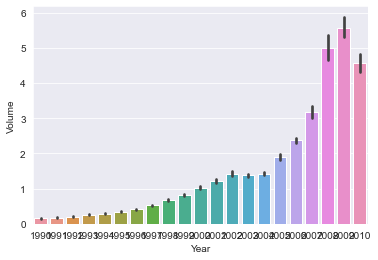

In [47]:
sns.barplot(df.Year, df.Volume)

Here is a barplot of `Year` and `Volume`. We can see from the graph that there is a trend that volume of trades increases over time.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


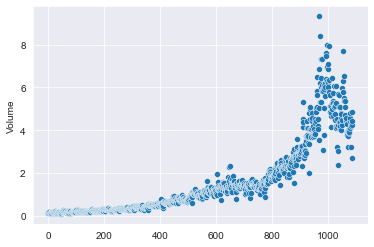

In [48]:
sns.scatterplot(df.index, df.Volume)

From this scatterplot,we can see that as index increases, `Volume` also increases which aligns with the barplot above

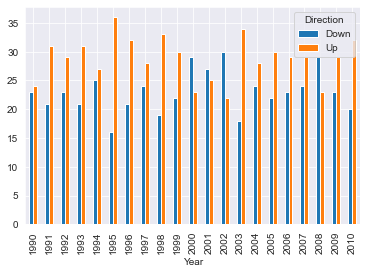

In [49]:
year_group = df.groupby(['Year', 'Direction'])
year_group.size().unstack().plot(kind='bar')

Here is a grouped plot of `Direction` over the year span 1990 to 2010. We can visualize from the plot that for the weeks in years 1990 through 1999 and 2003 through 2012 have a higher percentage direction of `Up` except for weeks in year 2008. Weeks in years 2000 through 2002 has a higher percentage of direction `Down`.

## b)

In [50]:
formula = 'Direction ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume'
smarket_glm = smf.glm(formula, data=df, family=sm.families.Binomial()).fit()
smarket_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Generalized Linear Model Regression Results                           
================================================================================================
Dep. Variable:     ['Direction[Down]', 'Direction[Up]']   No. Observations:                 1089
Model:                                              GLM   Df Residuals:                     1082
Model Family:                                  Binomial   Df Model:                            6
Link Function:                                    logit   Scale:                          1.0000
Method:                                            IRLS   Log-Likelihood:                -743.18
Date:                                  Thu, 23 Jun 2022   Deviance:                       1486.4
Time:                                          14:12:09   Pearson chi2:                 1.09e+03
No. Iterations:                                       4                                         
Covariance Type:                              nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2669      0.086     -3.106      0.002      -0.435      -0.098
Lag1           0.0413      0.026      1.563      0.118      -0.010       0.093
Lag2          -0.0584      0.027     -2.175      0.030      -0.111      -0.006
Lag3           0.0161      0.027      0.602      0.547      -0.036       0.068
Lag4           0.0278      0.026      1.050      0.294      -0.024       0.080
Lag5           0.0145      0.026      0.549      0.583      -0.037       0.066
Volume         0.0227      0.037      0.616      0.538      -0.050       0.095
==============================================================================
"""

In order to get the p-values, we first use the statsmodel technique to fit the logistic regression model. Looking at the p-values, we see that only `Lag2` has a p-value of 0.03 which is smaller than 0.05 so we can conclude that it is statistically signifcicant. Using the statsmodel gives an opposite coefficient for every independent variable as seen in problem 1 so for the correct encoding, I will use the sklearn method again. The p-values are not affected.

In [51]:
features = ['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']
response = 'Direction'

X = df[features]
y = df[response]

logistic_reg = LogisticRegression(penalty='none').fit(X,y)
print(logistic_reg.coef_)
print(logistic_reg.intercept_)

[[-0.04126771  0.05844169 -0.01606184 -0.02778928 -0.01447421 -0.02274122]]
[0.26686253]


Here are the coefficients and intercept of our fitted logistic regression model. 

## c)

In [52]:
y_pred = logistic_reg.predict(X)

cfm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0: "Down", 1:"Up"}, inplace = True)

df_cfm

,Down,Up
Down,54,430
Up,48,557


Here is the confusion matrix associated with the logistic regression model above. We can interpret this as there are 54 predictions that predicted down and is actually down; 557 predictions that predicted up and is actually up. This is the amount of accurate predictions.

In [53]:
acc = (tp+tn)/(tp+fn+tn+fp)
acc

0.5610651974288338

Here is the overall fraction of correct predictions: 0.561

There are two types of errors in the confusion matrix: false positives and false negatives. In this case, the confusion matrix tells us the false positives is 430 and false negatives is 48. 

## d)

In [54]:
df_train = df.loc[df.Year <= 2008]
df_test = df.loc[df.Year > 2008]
print("Training dataset shape: ", df_train.shape)
print("Test dataset shape: ", df_test.shape)

Training dataset shape:  (985, 9)
Test dataset shape:  (104, 9)


Here we split the data into training and test sets based on years in question. We can see that training dataset has 985 observations and test dataset has 104 observations. 

In [55]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

logistic_reg = LogisticRegression(penalty='none') 
logistic_reg.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = logistic_reg.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0: "Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down     9  34
Up       5  56


0.625

Here is the associated confusion matrix for the logistic regression model with `Lag2` as the only predictor. We see that the overall fraction of correct predictions for the testing dataset is 0.625

## e) 

In [56]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

lda_model = LDA()
lda_model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

Here we fit the LDA model.

In [57]:
X_test = df_test[features]
y_test = df_test[response]
y_pred = lda_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down     9  34
Up       5  56


0.625

Here is the associated confusion matrix for the LDA model with Lag2 as the only predictor. We see that the overall fraction of correct predictions for the testing dataset is 0.625.

## f)

In [58]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

qda_model = QDA()
qda_model.fit(X_train, y_train)


QuadraticDiscriminantAnalysis()

Here we fit the QDA model.

In [59]:
X_test = df_test[features]
y_test = df_test[response]
y_pred = qda_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down     0  43
Up       0  61


0.5865384615384616

Here is the associated confusion matrix for the QDA model with Lag2 as the only predictor. We see that the overall fraction of correct predictions for the testing dataset is 0.587.

## g)

In [60]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=1)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Here we fit the KNN model with K=1.

In [61]:
X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down    21  22
Up      30  31


0.5

Here is the associated confusion matrix for the KNN model with Lag2 as the only predictor. We see that the overall fraction of correct predictions for the testing dataset is 0.5.

## h)

In [62]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

gnb_model = GNB()
gnb_model.fit(X_train, y_train)

GaussianNB()

Here we fit the Gaussian Naive Bayes Model.

In [63]:
X_test = df_test[features]
y_test = df_test[response]
y_pred = gnb_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down     0  43
Up       0  61


0.5865384615384616

Here is the associated confusion matrix for the Naive Bayes model with Lag2 as the only predictor. We see that the overall fraction of correct predictions for the testing dataset is 0.587.

## i)

Comparing the overall fraction of correct predictions by the different models, the logistic regression model and the LDA model has the highest value: 0.625. So these two methods appear to provide the best results on the data.

## j)

Since logistic regression and LDA model had the highest value of fraction of correct predictions, we will make adjustments to these models to see if there are any further improvements.

### Experimenting with Logistic Regression

In [64]:
df['Lag2_squared'] = df['Lag2']**2

df_train = df.loc[df.Year <= 2008]
df_test = df.loc[df.Year > 2008]

features = ['Lag2_squared']
X_train = df_train[features]
y_train = df_train[response]

logistic_reg = LogisticRegression(penalty='none') 
logistic_reg.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = logistic_reg.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0: "Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down     0  43
Up       0  61


0.5865384615384616

We transform `Lag2` to take its square and fit this in the logistic regression model, the accuracy went down to 0.587.

In [65]:
df['Lag2_sqrt'] = df['Lag2']**1/2

df_train = df.loc[df.Year <= 2008]
df_test = df.loc[df.Year > 2008]

features = ['Lag2_sqrt']
X_train = df_train[features]
y_train = df_train[response]

logistic_reg = LogisticRegression(penalty='none') 
logistic_reg.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = logistic_reg.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0: "Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down     9  34
Up       5  56


0.625

We transform `Lag2` to take its square root and fit this in the logistic regression model, the accuracy remains the same.

In [66]:
features = ['Lag1', 'Lag2']
X_train = df_train[features]
y_train = df_train[response]

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
X_train_int = pd.DataFrame(interaction.fit_transform(X_train)) 

logistic_reg = LogisticRegression(penalty='none') 
logistic_reg.fit(X_train_int, y_train)

X_test = df_test[features]
X_test_int = pd.DataFrame(interaction.fit_transform(X_test)) 
y_test = df_test[response]
y_pred = logistic_reg.predict(X_test_int)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0: "Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down     7  36
Up       8  53


0.5769230769230769

I chose `Lag1` to produce an interaction term since it had the smallest p-value compared to other variables. We see that the accuracy decreased to 0.577. 

### Experimenting with LDA

In [67]:
df['Lag2_squared'] = df['Lag2']**2

df_train = df.loc[df.Year <= 2008]
df_test = df.loc[df.Year > 2008]

features = ['Lag2_squared']
X_train = df_train[features]
y_train = df_train[response]

lda_model = LDA()
lda_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = lda_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down     0  43
Up       0  61


0.5865384615384616

In [68]:
df['Lag2_sqrt'] = df['Lag2']**1/2

df_train = df.loc[df.Year <= 2008]
df_test = df.loc[df.Year > 2008]

features = ['Lag2_sqrt']
X_train = df_train[features]
y_train = df_train[response]

lda_model = LDA()
lda_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = lda_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down     9  34
Up       5  56


0.625

In [69]:
features = ['Lag1', 'Lag2']
X_train = df_train[features]
y_train = df_train[response]

interaction = PolynomialFeatures(include_bias=False, interaction_only=True)
X_train_int = pd.DataFrame(interaction.fit_transform(X_train)) 

lda_model = LDA()
lda_model.fit(X_train_int, y_train)

X_test = df_test[features]
X_test_int = pd.DataFrame(interaction.fit_transform(X_test)) 
y_test = df_test[response]
y_pred = lda_model.predict(X_test_int)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0: "Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down     7  36
Up       8  53


0.5769230769230769

Running the same transformations and interactions as in the logistic regression model, we don't see any improvement in accuracy. Best accuracy is still 0.625 by the original logistic regression and LDA.

### Experimenting with Different K values for KNN 

### K=5 

In [70]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=5)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc


      Down  Up
Down    16  27
Up      22  39


0.5288461538461539

When K=5, we see that the accuracy increased from 0.5 to 0.529.

### K=10

In [71]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=10)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down    22  21
Up      24  37


0.5673076923076923

When K=10, we see that the accuracy increased from 0.529 to 0.567.

### K=20

In [72]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=20)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down    23  20
Up      22  39


0.5961538461538461

When K=20, we see that the accuracy increased from 0.567 to 0.596.

### K=50

In [73]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=50)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down    22  21
Up      24  37


0.5673076923076923

When K=50, we see that the accuracy is 0.567.

## K=100

In [74]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=100)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down    11  32
Up      13  48


0.5673076923076923

When K=100, the accuracy is 0.567.

### K=150

In [75]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=150)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down    10  33
Up       6  55


0.625

When K=150, we see that the accuracy is 0.625 which matches the answer is part i to provide the best results.

### K=200

In [76]:
features = ['Lag2']
X_train = df_train[features]
y_train = df_train[response]

knn_model = KNN(n_neighbors=200)
knn_model.fit(X_train, y_train)

X_test = df_test[features]
y_test = df_test[response]
y_pred = knn_model.predict(X_test)

cfm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cfm.ravel()
cfm

df_cfm = pd.DataFrame(cfm)
df_cfm.rename(columns = {0:'Down', 1:'Up'}, inplace = True)
df_cfm.rename(index = {0:"Down", 1:"Up"}, inplace = True)

print(df_cfm)

acc = (tp+tn)/(tp+fn+tn+fp)
acc

      Down  Up
Down     3  40
Up       1  60


0.6057692307692307

When K=200, we see that the accuracy is 0.606.

Therefore, KNN can achieve an accuracy of 0.625 which is the highest among all classifiers so far. 

# 3 Bootstrap Probabilities

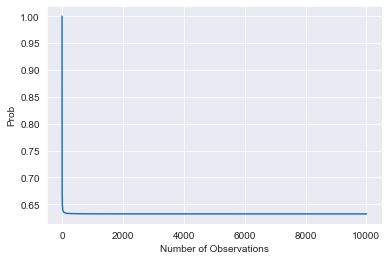

In [77]:
x = np.arange(1, 10001)
y = 1-(1-1/x)**x

plt.plot(x,y)
plt.xlabel("Number of Observations")
plt.ylabel("Prob")

plt.show()

In [78]:
np.random.seed(1)
list1 = []
for i in range(0, 10000):
    i = np.sum(np.random.choice(100, 100, replace=True)==4) > 0
    list1.append(i)

np.mean(list1)

0.6302